# Mode Diagnostics: Wait + Travel

Unified exploratory notebook covering wait-time and travel-time fits. All heavy lifting lives in `src/modeling` helpers, so this document just orchestrates the dashboards and reference snapshots.

In [42]:
import sys
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display

In [43]:
# Add src/ to path for project helpers
root = Path.cwd().resolve()
for candidate in [root, *root.parents]:
    src_dir = candidate / "src"
    if src_dir.exists():
        sys.path.append(str(src_dir))
        break

from modeling.wait_dashboard import (
    WaitDashboard,
    load_bike_dataset,
    load_taxi_dataset,
    render_wait_snapshot,
)
from modeling.travel_diagnostics import load_travel_diagnostics

In [44]:
# Downsample large raw datasets to keep memory usage manageable.
WAIT_TAXI_MAX_ROWS = 2000_000
WAIT_BIKE_MAX_ROWS = 2000_000
TRAVEL_TAXI_MAX_ROWS = 2000_000
TRAVEL_BIKE_MAX_ROWS = 2000_000

In [45]:
# Load datasets for both components
wait_taxi = load_taxi_dataset(max_rows=WAIT_TAXI_MAX_ROWS)
wait_bike = load_bike_dataset(max_rows=WAIT_BIKE_MAX_ROWS)
travel_diag = load_travel_diagnostics(
    taxi_max_rows=TRAVEL_TAXI_MAX_ROWS,
    bike_max_rows=TRAVEL_BIKE_MAX_ROWS,
)

Loading 6 taxi files...
  Reading yellow_tripdata_2024-01.parquet...
  Reading yellow_tripdata_2024-02.parquet...
  Reading yellow_tripdata_2024-03.parquet...
  Reading yellow_tripdata_2024-04.parquet...
  Reading yellow_tripdata_2024-05.parquet...
  Reading yellow_tripdata_2024-06.parquet...
Loaded 11,958,006 taxi trips across 57 active zones (Jan-Jun 2024)
Loaded 18,795,711 bike trips across 704 active stations
[taxi] Loading yellow_tripdata_2024-01.parquet ...
[taxi] Loading yellow_tripdata_2024-02.parquet ...
[taxi] Loading yellow_tripdata_2024-03.parquet ...
[taxi] Loading yellow_tripdata_2024-04.parquet ...
[taxi] Loading yellow_tripdata_2024-05.parquet ...
[taxi] Loading yellow_tripdata_2024-06.parquet ...
Loading Citi Bike trips ...


/Users/atharvramesh/UCSD/Fall2025/ECE225A/NYC_Public_Transit/src/modeling/travel_diagnostics.py:154: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Wait-time dashboards

In [46]:
taxi_dashboard = WaitDashboard(wait_taxi, "🚕 Taxi Dashboard")
bike_dashboard = WaitDashboard(wait_bike, "🚲 Bike Dashboard")

tabs = widgets.Tab(children=[taxi_dashboard.widget, bike_dashboard.widget])
tabs.set_title(0, "Taxi")
tabs.set_title(1, "Citi Bike")
display(tabs)

### Wait-time snapshots

Selection too sparse (mean=0.56, nonzero=0.41).

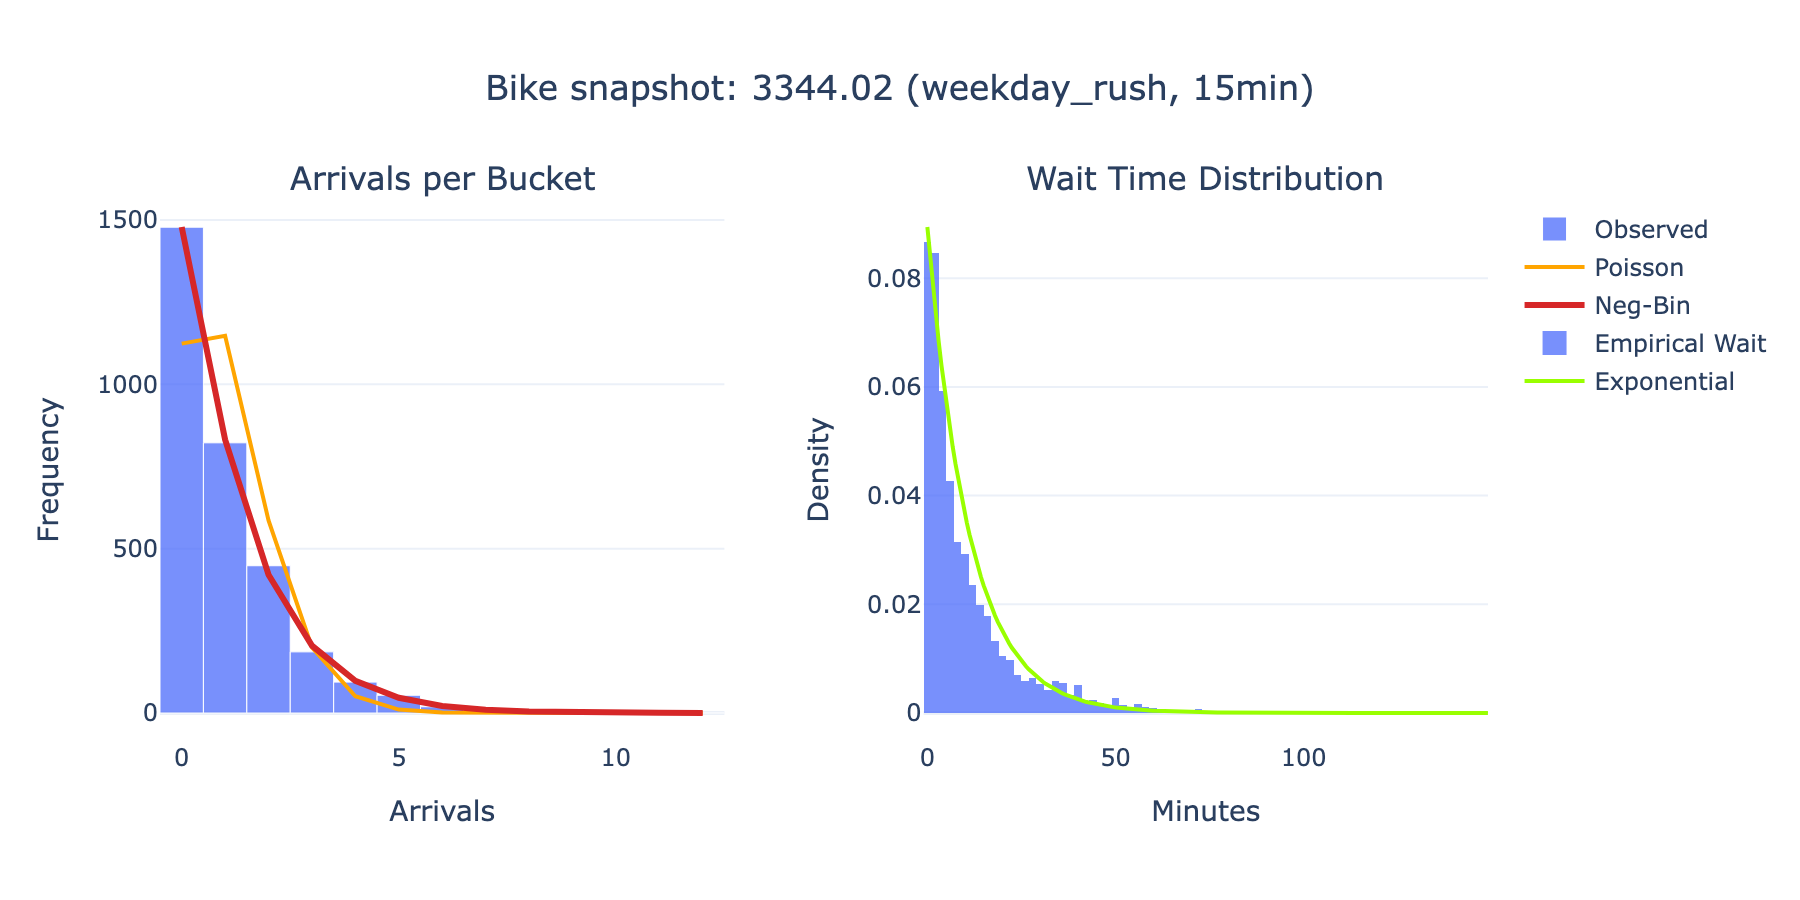

In [47]:
if wait_taxi.locations:
    render_wait_snapshot(
        wait_taxi,
        wait_taxi.locations[0],
        cohort="weekday_rush",
        title_prefix="Taxi snapshot",
    )

if wait_bike.locations:
    render_wait_snapshot(
        wait_bike,
        wait_bike.locations[0],
        cohort="weekday_rush",
        title_prefix="Bike snapshot",
    )

### Wait-time curves by cohort
The plot below compares the exponential wait-time models for one taxi zone across weekday/weekend and rush/off-peak cohorts. Edit `TARGET_ZONE` or swap in `wait_bike` to explore other locations.

In [57]:
import numpy as np
import plotly.graph_objects as go

# TARGET_ZONE = wait_taxi.locations[0] if wait_taxi.locations else None
TARGET_CATCHMENT = wait_bike.locations[0] if wait_bike.locations else None

if TARGET_CATCHMENT is None:
    raise ValueError('No bike locations available.')
print(f'Using bike catchment: {TARGET_CATCHMENT}')

def exponential_curve(dataset, location, *, is_weekend, is_rush):
    subset = dataset.trips[
        (dataset.trips[dataset.group_col] == location)
        & (dataset.trips['is_weekend'] == is_weekend)
        & (dataset.trips['is_rush'] == is_rush)
    ].sort_values('event_time')
    diffs = subset['event_time'].diff().dt.total_seconds() / 60.0
    diffs = diffs[(diffs > 0.01) & (diffs < 180)]
    return diffs

combos = [
    ('Weekday rush', False, True),
    ('Weekday off-peak', False, False),
    ('Weekend rush', True, True),
    ('Weekend off-peak', True, False),
]
fig = go.Figure()
for label, is_weekend, is_rush in combos:
    samples = exponential_curve(wait_bike, TARGET_CATCHMENT, is_weekend=is_weekend, is_rush=is_rush)
    if samples.empty:
        continue
    mean_wait = samples.mean()
    if not mean_wait or mean_wait <= 0:
        continue
    lam = 1.0 / mean_wait
    x_max = min(45, mean_wait * 6)
    x = np.linspace(0, x_max, 200)
    y = lam * np.exp(-lam * x)
    fig.add_trace(
        go.Scatter(
            x=x,
            y=y,
            mode='lines',
            name=f'{label} (mean {mean_wait:.1f} min)',
        )
    )
fig.update_layout(
    title=f'Exponential wait-time curves for {TARGET_ZONE}',
    xaxis_title='Minutes',
    yaxis_title='Density',
    template='plotly_white',
)
fig

Using bike catchment: 3344.02


## Travel-time summaries

In [49]:
display(travel_diag.bin_stats_summary().head(12))
display(travel_diag.low_sample_bins())
display(travel_diag.gamma_coverage())
display(travel_diag.sample_counts_table().head(20))

,mode,distance_bin,cohorts,min_samples,median_samples,max_samples
0,bike,0-2km,4,877241,2904279.5,4861186
2,bike,2-4km,4,379535,1217184.5,1805422
3,bike,4-6km,4,122447,381032.0,533374
4,bike,6-8km,4,40043,125132.0,176795
5,bike,8-10km,4,12909,40936.0,59353
1,bike,10-12km,4,4170,12572.5,19216
6,taxi,0-2km,4,270797,894772.0,1919085
8,taxi,2-4km,4,262428,864520.5,1855600
9,taxi,4-6km,4,99951,315144.0,700354
10,taxi,6-8km,4,40239,126060.5,286409


,mode,distance_bin,is_rush,is_weekend,sample_count,meets_gamma
23,bike,10-12km,True,True,4170,True
21,bike,10-12km,False,True,10090,True
19,bike,8-10km,True,True,12909,True
47,taxi,10-12km,True,True,13199,True
22,bike,10-12km,True,False,15055,True
20,bike,10-12km,False,False,19216,True
43,taxi,8-10km,True,True,20951,True
17,bike,8-10km,False,True,30537,True
15,bike,6-8km,True,True,40043,True
39,taxi,6-8km,True,True,40239,True


,fraction_gamma_ready
mode,
bike,1.0
taxi,1.0


,mode,distance_bin,rush_label,weekend_label,sample_count,meets_gamma
0,bike,0-2km,Off-peak,Weekday,4861186,True
1,bike,0-2km,Off-peak,Weekend,1994288,True
2,bike,0-2km,Rush,Weekday,3814271,True
3,bike,0-2km,Rush,Weekend,877241,True
4,bike,2-4km,Off-peak,Weekday,1805422,True
5,bike,2-4km,Off-peak,Weekend,876599,True
6,bike,2-4km,Rush,Weekday,1557770,True
7,bike,2-4km,Rush,Weekend,379535,True
8,bike,4-6km,Off-peak,Weekday,533374,True
9,bike,4-6km,Off-peak,Weekend,283884,True


### Gamma diagnostics

In [50]:
gamma_dashboard = travel_diag.build_gamma_dashboard()
display(gamma_dashboard)

### Gamma snapshot

**Gamma overlay — Bike, 0-2km, Off-peak, Weekday**

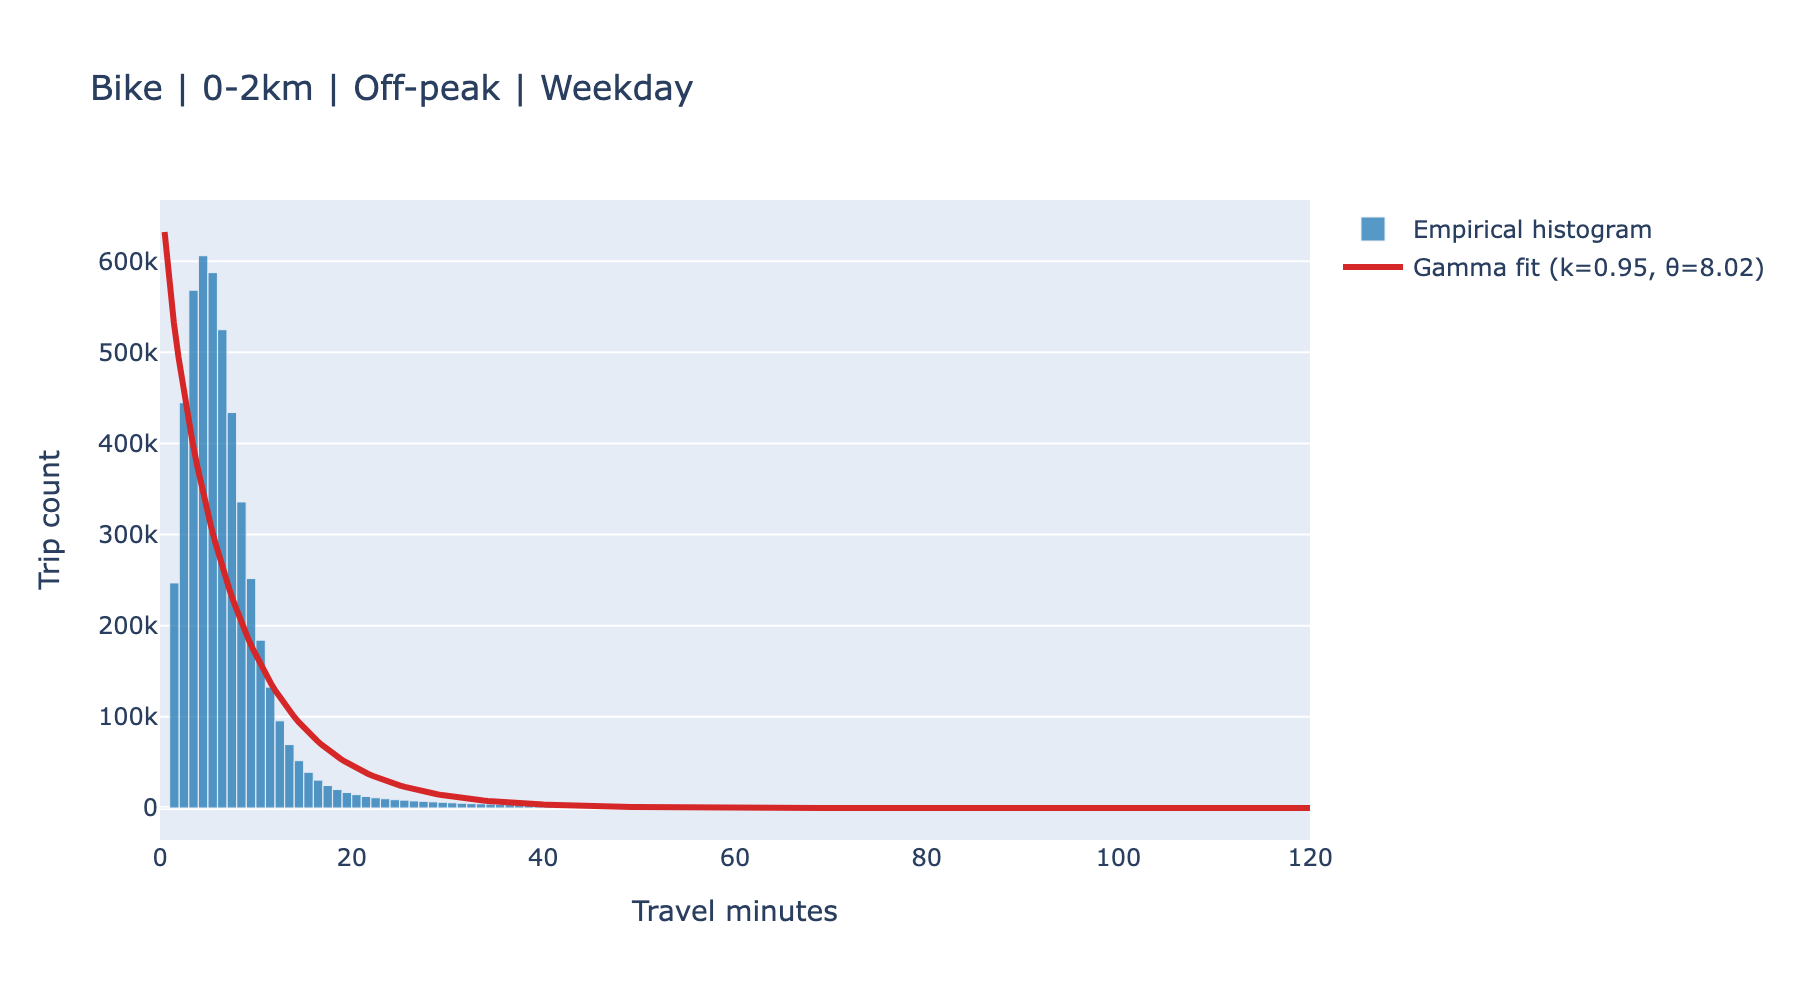

sample_count    4.861186e+06
mean_minutes    7.647019e+00
var_minutes     6.131731e+01
gamma_k         9.536768e-01
gamma_theta     8.018460e+00
overall_mean    7.647019e+00
overall_var     6.131731e+01
Name: metrics, dtype: float64

In [51]:
travel_diag.render_gamma_snapshot(
    mode="bike",
    distance_bin=travel_diag.distance_levels[0] if travel_diag.distance_levels else None,
    is_rush=False,
    is_weekend=False,
    title_prefix="Gamma overlay",
)

### Lognormal overlays

In [52]:
lognorm_dashboard = travel_diag.build_lognormal_overlay_dashboard()
display(lognorm_dashboard)

### Lognormal snapshot

**Gamma vs lognormal — Bike, 0-2km, Off-peak, Weekday**

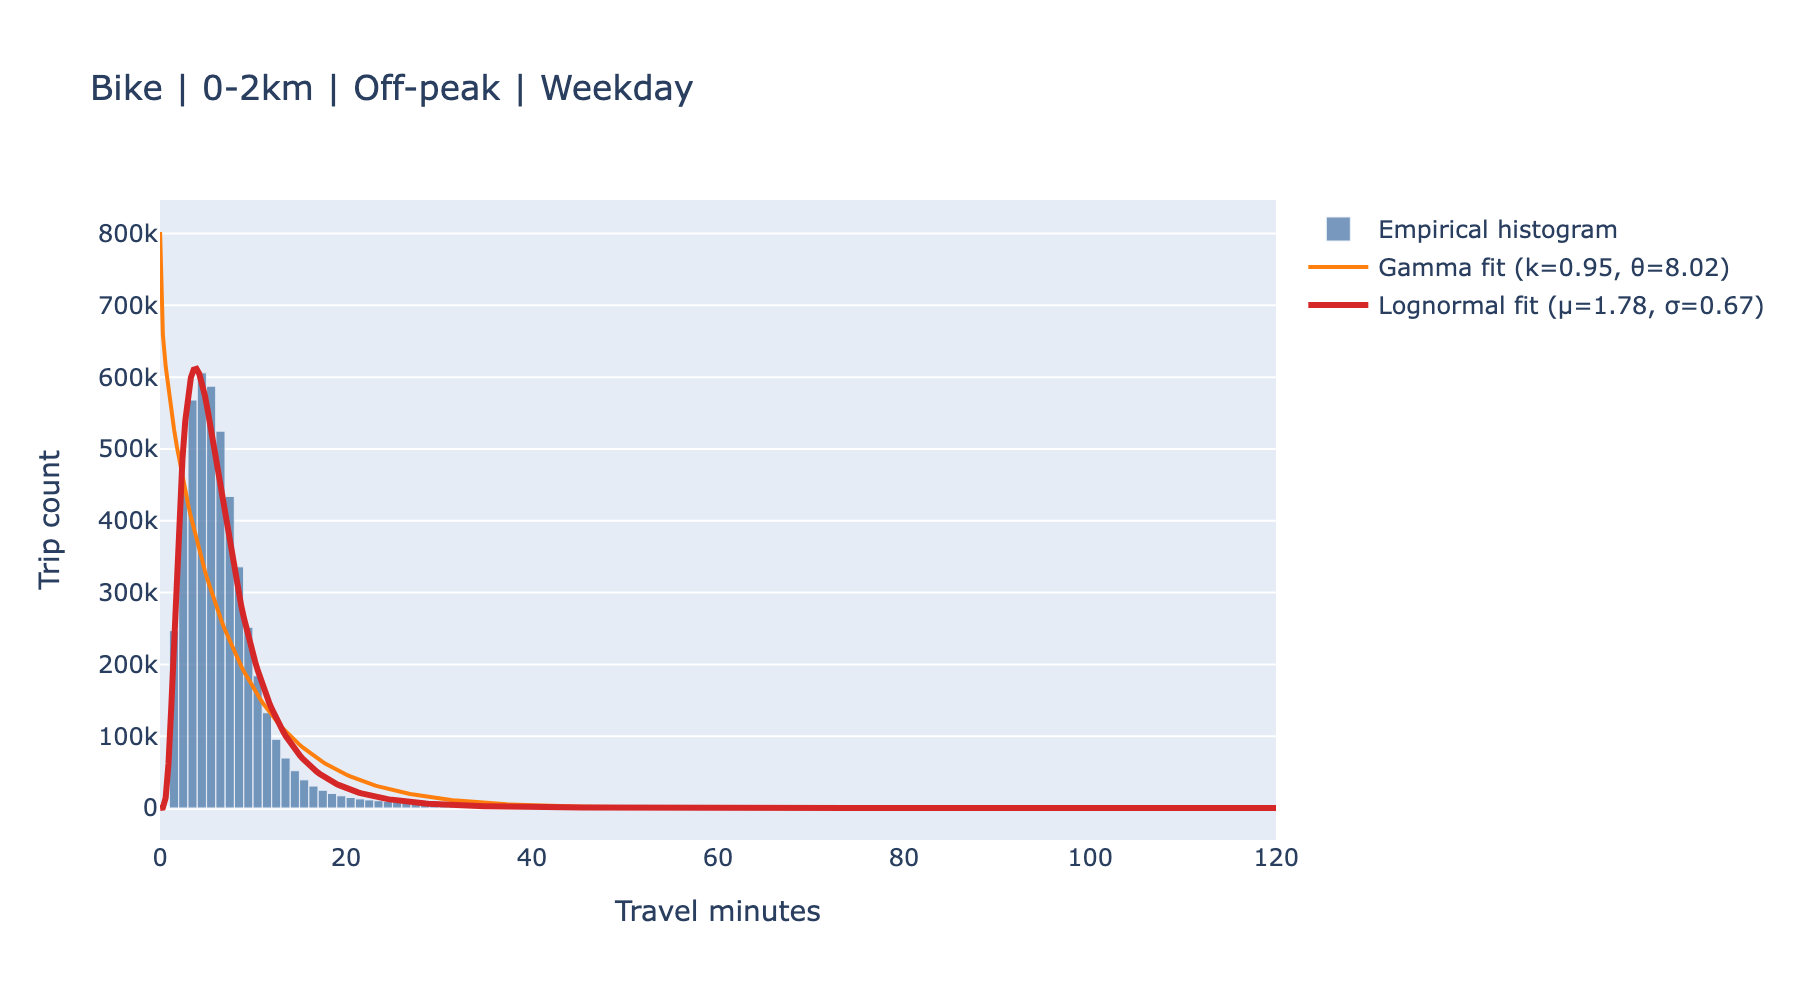

mu_log           1.780819
sigma_log        0.666634
samples           4861186
gamma_samples     4861186
gamma_mean       7.647019
bike_type             all
Name: distribution_params, dtype: object

In [53]:
travel_diag.render_lognormal_snapshot(
    mode="bike",
    distance_bin=travel_diag.distance_levels[0] if travel_diag.distance_levels else None,
    is_rush=False,
    is_weekend=False,
    title_prefix="Gamma vs lognormal",
)

### Lognormal GLM summary

In [54]:
display(travel_diag.lognormal_summary())
display(travel_diag.lognormal_coeff_table())

,mode,samples,sigma_log,r_squared_log,mae_log
0,bike,18253964,0.484524,0.621638,0.330788
1,taxi,10369814,0.392466,0.617878,0.302140


,const,distance_km,distance_sq,is_rush,is_weekend,is_ebike,sigma_log
bike,1.217589,0.701873,-0.049062,-0.024662,0.079274,-0.193375,0.484524
taxi,1.257183,0.510235,-0.031931,0.050923,-0.111095,0.000000,0.392466


### Model comparison summary
The table below contrasts raw-minute errors for the Gamma cohort means versus the lognormal GLM.

In [ ]:
error_table = travel_diag.error_metrics_table()
display(error_table)

### Lognormal GLM diagnostics

In [55]:
log_glm_dashboard = travel_diag.build_lognormal_diag_dashboard()
display(log_glm_dashboard)

### Log-likelihood and error metrics

In [56]:
ll_summary, per_trip, overall_delta, comparable = travel_diag.log_likelihood_tables()
display(ll_summary)
display(per_trip)
print(f"Overall Δ log-likelihood (lognormal - gamma): {overall_delta:,.2f} across {comparable:,} comparable trips")

display(travel_diag.error_metrics_table())

,gamma_loglike,lognormal_loglike,delta
mode,,,
bike,-5.791212e+07,-5.256265e+07,5.349466e+06
taxi,-3.037606e+07,-2.952035e+07,8.557122e+05


,gamma_mean,lognormal_mean
mode,,
bike,-3.172578,-2.879520
taxi,-2.929277,-2.846757


Overall Δ log-likelihood (lognormal - gamma): 6,205,178.25 across 28,623,778 comparable trips


,mode,model,samples,mae_min,rmse_min
0,bike,lognormal_glm,18253964,4.372902,8.472546
1,bike,gamma_bin,18253964,4.782646,8.380351
2,taxi,lognormal_glm,10369814,3.801039,5.638720
3,taxi,gamma_bin,10369814,3.947653,5.638244
